#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

### Import required modules

In [1]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler


### Input parameters

In [2]:
dload = './saved_model' #download directory

### utils.load_data

In [3]:
def load_gen_data(file_name, cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1]
    TEST_DF = TEST_DF.iloc[:,1:-1]
    
    scaler = MinMaxScaler()
    
    TRAIN_SCALED_DF = scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED_DF = scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_SCALED_DF, TEST_SCALED_DF

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [4]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_DF.shape)
print(TEST_DF.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [5]:
TRAIN_DF

array([[3.66328864e-04, 2.52639355e-05, 2.90615333e-05, ...,
        3.42446043e-01, 4.98597475e-01, 1.65289256e-01],
       [2.66795942e-04, 3.25753827e-05, 3.13032504e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.65289256e-01],
       [2.01613776e-04, 1.37864421e-05, 3.04728091e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.23966942e-01],
       ...,
       [2.66813941e-03, 9.48559406e-04, 3.24553957e-06, ...,
        6.04316547e-01, 9.89481066e-01, 2.89256198e-01],
       [1.45200665e-03, 2.26151271e-03, 3.08280452e-06, ...,
        6.04316547e-01, 9.88779804e-01, 3.05785124e-01],
       [8.30917887e-03, 8.96945321e-04, 7.79900694e-06, ...,
        6.04316547e-01, 9.88779804e-01, 2.97520661e-01]])

In [6]:
TEST_DF

array([[4.02355635e-03, 6.62881732e-05, 1.69243372e-05, ...,
        6.79136691e-01, 3.52033661e-01, 2.14876033e-01],
       [4.07135202e-03, 1.18662977e-04, 6.92800865e-06, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       [4.02378633e-03, 2.82489361e-04, 2.07942738e-05, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       ...,
       [3.98419630e-03, 7.85747554e-05, 1.75819403e-05, ...,
        5.98561151e-01, 4.25666199e-01, 2.56198347e-01],
       [3.98799304e-03, 4.90275879e-05, 3.81572787e-06, ...,
        6.00000000e-01, 4.24964937e-01, 2.56198347e-01],
       [3.93781591e-03, 3.97621553e-05, 8.13602856e-06, ...,
        6.04316547e-01, 4.24964937e-01, 2.47933884e-01]])

In [7]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [8]:
window = 100

In [9]:
train_dataset = GenerationDataset(TRAIN_DF, window)
train_dataset

In [10]:
test_dataset = GenerationDataset(TEST_DF, window)
test_dataset

In [11]:
train_dataset[0].shape

torch.Size([100, 92])

**Fetch `sequence_length` from dataset**

In [12]:
sequence_length = train_dataset[0].shape[0]
sequence_length

100

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [13]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [14]:
n_epochs = 10
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0005
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [15]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [16]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 17.2607, recon_loss = 17.2308, kl_loss = 0.0300
Batch 60, loss = 1.0192, recon_loss = 0.7428, kl_loss = 0.2764
Batch 90, loss = 1.2719, recon_loss = 1.1037, kl_loss = 0.1682
Batch 120, loss = 1.1252, recon_loss = 0.9868, kl_loss = 0.1384
Batch 150, loss = 110.3502, recon_loss = 110.0484, kl_loss = 0.3019
Batch 180, loss = 33.3222, recon_loss = 33.1574, kl_loss = 0.1649
Batch 210, loss = 145.5286, recon_loss = 145.3427, kl_loss = 0.1859
Average loss: 38.9272
Epoch: 1
Batch 30, loss = 18.8910, recon_loss = 18.8075, kl_loss = 0.0835
Batch 60, loss = 0.9281, recon_loss = 0.8554, kl_loss = 0.0728
Batch 90, loss = 1.1660, recon_loss = 1.0664, kl_loss = 0.0997
Batch 120, loss = 0.6524, recon_loss = 0.5681, kl_loss = 0.0843
Batch 150, loss = 128.0257, recon_loss = 127.8613, kl_loss = 0.1644
Batch 180, loss = 51.9307, recon_loss = 51.7552, kl_loss = 0.1754
Batch 210, loss = 93.1384, recon_loss = 93.0669, kl_loss = 0.0715
Average loss: 43.6568
Epoch: 2
Batch 30, loss = 

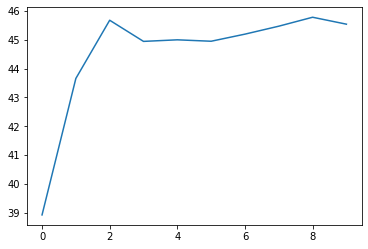

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [18]:
vrae.save('vrae.pth')

# To load a presaved model, execute:
# vrae.load('vrae.pth')

In [19]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [20]:
z_run = vrae.transform(test_dataset)
z_run

array([[ 6.78621769e-01,  6.41180277e-01, -1.07185698e+00,
        -3.60839427e-01, -3.73065680e-01,  7.25541234e-01,
        -1.00064301e+00,  1.16140497e+00, -2.83469826e-01,
        -6.01046622e-01, -1.50305197e-01,  3.38497683e-02,
         7.25846291e-01, -6.85653329e-01,  5.02130128e-02,
         2.35655427e-01,  1.54280365e-01, -8.75921011e-01,
        -2.34609619e-01,  1.02108634e+00],
       [ 6.78124905e-01,  6.38966918e-01, -1.07427108e+00,
        -3.63327205e-01, -3.74683857e-01,  7.23096728e-01,
        -9.99035776e-01,  1.15799403e+00, -2.83488959e-01,
        -6.02683723e-01, -1.47499427e-01,  3.36270854e-02,
         7.26484299e-01, -6.86457276e-01,  5.36962338e-02,
         2.37272739e-01,  1.53463200e-01, -8.76969934e-01,
        -2.32551992e-01,  1.01991343e+00],
       [ 6.83080852e-01,  6.43902004e-01, -1.07806647e+00,
        -3.61071825e-01, -3.74351352e-01,  7.28027165e-01,
        -1.00492501e+00,  1.16427028e+00, -2.86816746e-01,
        -6.05969429e-01, -1.4

In [21]:
z_run.shape

(36, 20)

### Reconstruct

In [22]:
TRAIN_DF.shape

(22363, 92)

In [23]:
# train reconstruct
train_reconstruction = vrae.reconstruct(train_dataset)
print(train_reconstruction.shape)
train_reconstruction

(100, 223, 92)


array([[[-1.04409447e-02,  4.40706313e-03, -2.94012204e-03, ...,
          5.97585082e-01,  6.82357371e-01,  2.60543883e-01],
        [-1.03578847e-02,  4.36171703e-03, -3.04929912e-03, ...,
          5.97973704e-01,  6.82868183e-01,  2.60592878e-01],
        [-1.03606926e-02,  4.35672887e-03, -3.05896997e-03, ...,
          5.98013520e-01,  6.82923675e-01,  2.60610014e-01],
        ...,
        [ 5.53201139e-02, -2.62989476e-03, -1.17704347e-02, ...,
          8.50748897e-01,  9.55315471e-01,  3.19215149e-01],
        [ 5.71447238e-02, -2.66385823e-03, -1.20210983e-02, ...,
          8.56693864e-01,  9.61848021e-01,  3.20571721e-01],
        [-5.26120327e-03,  4.55626100e-03, -3.25719640e-03, ...,
          6.20221972e-01,  7.07035184e-01,  2.65761763e-01]],

       [[ 6.27106428e-03,  3.21529433e-03, -3.65344435e-03, ...,
          6.46744370e-01,  7.24317670e-01,  2.69422978e-01],
        [ 6.30193017e-03,  3.17924097e-03, -3.68959829e-03, ...,
          6.47042871e-01,  7.24772036e

In [24]:
TEST_DF.shape

(3627, 92)

In [25]:
# test reconstruct
test_reconstruction = vrae.reconstruct(test_dataset)
print(test_reconstruction.shape)
test_reconstruction

(100, 36, 92)


array([[[ 0.0504517 , -0.00146345, -0.00972446, ...,  0.83463794,
          0.935307  ,  0.31601697],
        [ 0.05045105, -0.00144963, -0.00968015, ...,  0.83450603,
          0.93516016,  0.31597477],
        [ 0.05070828, -0.00152161, -0.00974181, ...,  0.83551186,
          0.9362943 ,  0.3161918 ],
        ...,
        [ 0.05194508, -0.00153281, -0.01006465, ...,  0.83950996,
          0.9406751 ,  0.31713304],
        [ 0.05227333, -0.00166186, -0.0102048 , ...,  0.84056497,
          0.9420481 ,  0.31730893],
        [ 0.05233347, -0.00173804, -0.0102682 , ...,  0.8408532 ,
          0.94242716,  0.3173618 ]],

       [[ 0.05224435,  0.00097335,  0.00460547, ...,  0.8081162 ,
          0.93519455,  0.30926707],
        [ 0.05223872,  0.00097319,  0.00460013, ...,  0.80802697,
          0.935107  ,  0.30923772],
        [ 0.05243772,  0.00095632,  0.00463166, ...,  0.808685  ,
          0.9359569 ,  0.30938393],
        ...,
        [ 0.05348985,  0.00104677,  0.00479847, ...,  